In [1]:
import lightkurve as lk
import vetting as vt

In [2]:
# from s0048-s0048:TCE1
# see: https://exo.mast.stsci.edu/exomast_planet.html?planet=TIC330795464S0048S0048TCE1
# for TCE's centroid offset diagnostics.
tic, sector = 330795464, 48  # quite a few other sectors too
t0=2617.8403
duration=6.0456 / 24
period=16.968976

In [3]:
download_dir = "../../data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector)
tpf = sr.download(download_dir=download_dir)
tpf

TessTargetPixelFile(TICID: 330795464)

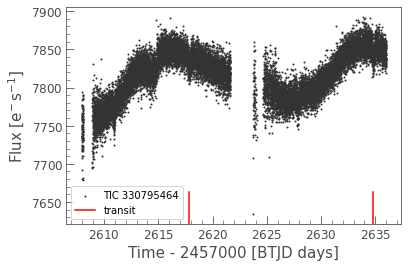

In [4]:
ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();
ax.axvline(t0 + period, c='red', ymax=0.15, label="transit");

726

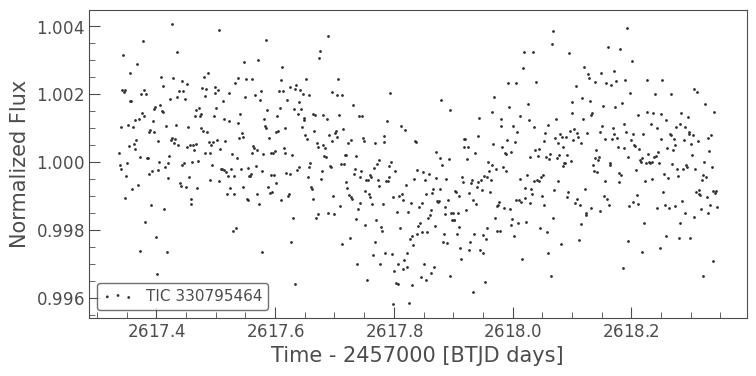

In [5]:
# experiment: see if use only the tpf around a dip would make the detection easier
tpf_trunc = tpf[(2617.8403 - (duration/2) * 4 < tpf.time.value) & (tpf.time.value < 2617.8403 + (duration/2) * 4)]
tpf_trunc.to_lightcurve().remove_outliers(sigma=7).normalize().scatter();
len(tpf_trunc)

([array([ True])],
 [(2.775401548914604e-09,)],
 [(5.550803097828957e-09,)],
 [(2.5254833756991115e-22,)],
 dict_keys(['figs', 'pvalues', 'pvalues_x', 'pvalues_y', 'centroid_offset_detected', 'lc_list', 'tpf_m_list', 'diagnostics_figs']))

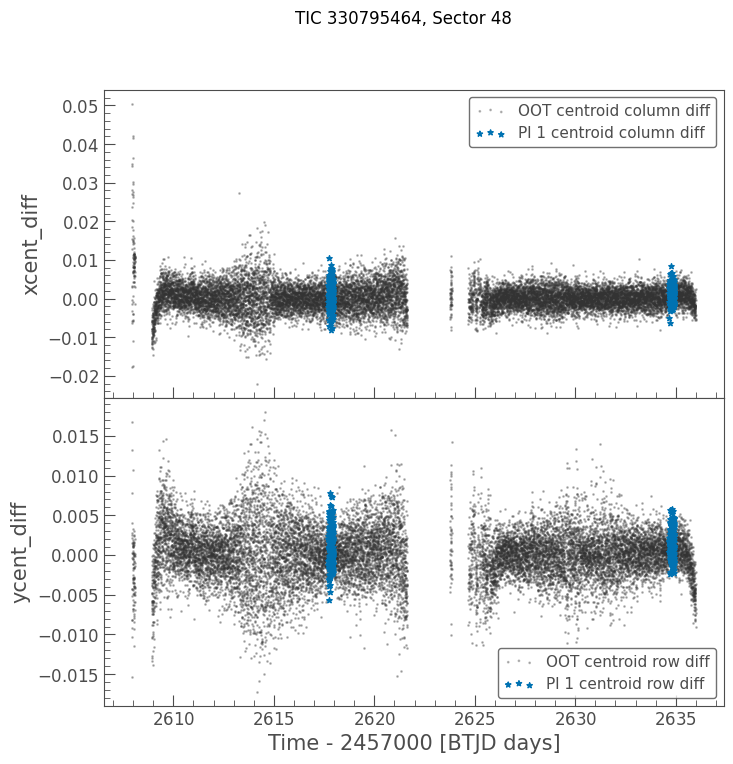

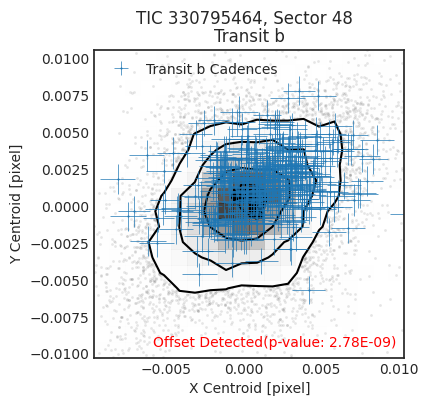

In [7]:
# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
# UNEXPECTED result: the test does not report signficant centroid shift, even though it is due to a NEB
r = vt.centroid_test(tpf, period, t0, duration, aperture_mask='pipeline', plot=True,
                     include_diagnostics=True,
                     kernel=20*15+1, # 30-minute cadence: 21 (default), 2-minute cadence: 20*15+1
                     nsamp=100,
#                    transit_depths=0.003,
                    );
( 
    r['centroid_offset_detected'],
    r['pvalues'], 
    r['pvalues_x'],
    r['pvalues_y'],
    r.keys(), 
)

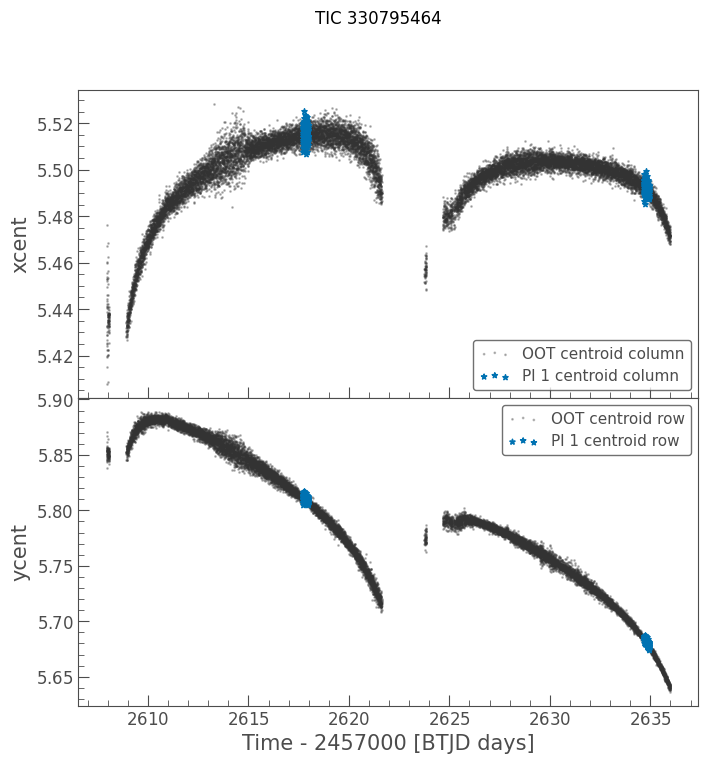

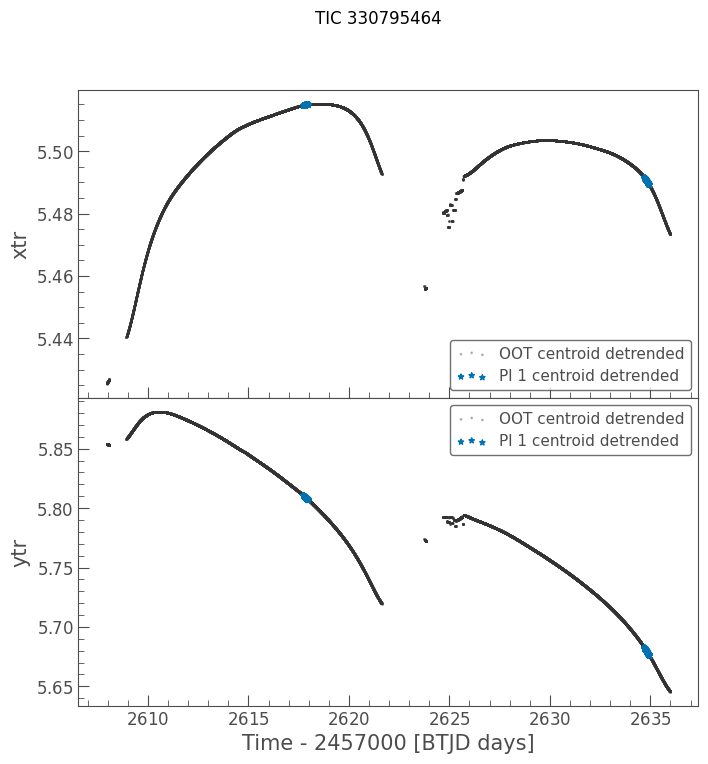

In [12]:
# reload(vt.centroiding)
# reload(vt)

# plot estimated centroids / detrended centroids to check if the detrending is over/under aggressive
lc = r['lc_list'][0]
fig1 = vt.centroiding.plot_centroids_vs_time(lc, "cent");
fig2 = vt.centroiding.plot_centroids_vs_time(lc, "tr");

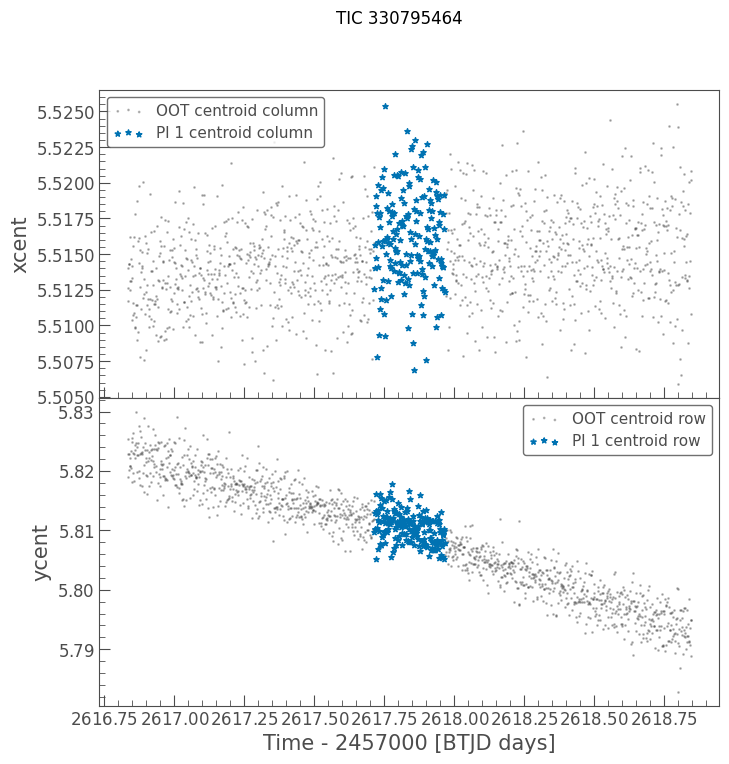

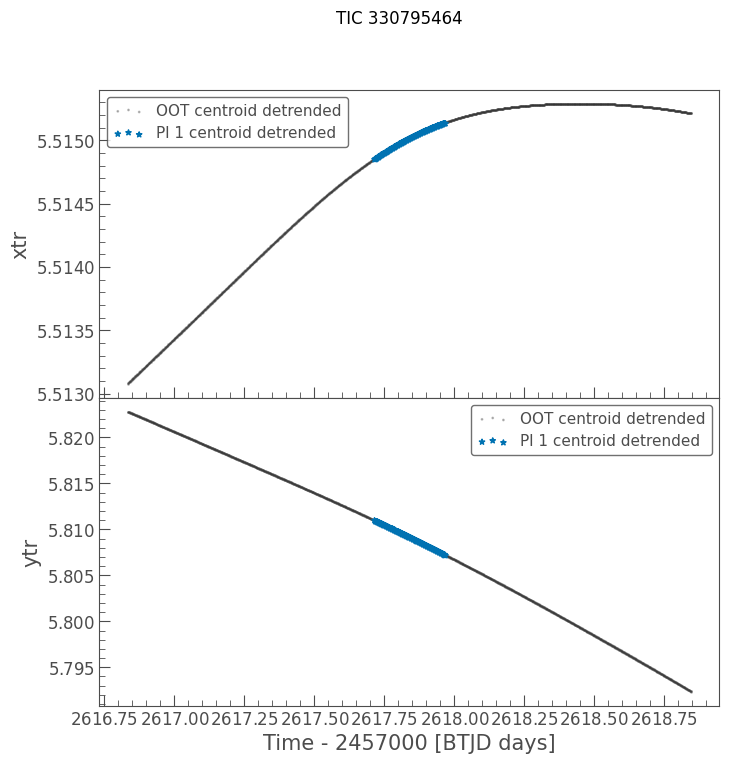

In [13]:
# zoom in to a dip to inspect again
lc_trunc = r['lc_list'][0].truncate(t0 - duration * 4, t0 + duration * 4)
fig1 = vt.centroiding.plot_centroids_vs_time(lc_trunc, "cent");
fig2 = vt.centroiding.plot_centroids_vs_time(lc_trunc, "tr");

In [11]:
vt.centroiding.print_power_analysis(r['lc_list'][0])

Power Analysis for TIC 330795464:
  OOT sample size size: 16749 ; col err: 0.0011895057937382056px, row err: 0.0011027721696825839px
  Pl 1 sample size: 363
  - has adequate power for 0.14863810677726152 sigma diff
  - actual col sigma diff: 0.8660431241618283 ; valid: True
  - actual row sigma diff: 1.250467397710754 ; valid: True


In [ ]:
ax = tpf_trunc.plot_pixels(aperture_mask="pipeline", show_flux=True);

Sector 48 TCE centroid offset diagnostics:

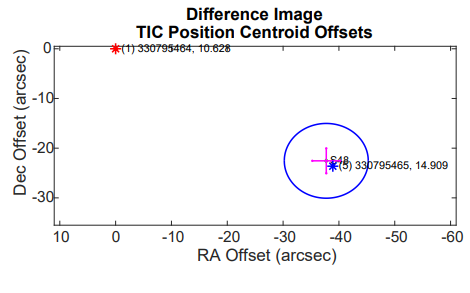
